# Sentiment Analysis in IMDB dataset with TF-IDF Bag of Words model

## Name: Rafael Gonçalves

### Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import torch
import tqdm
import time
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from multiprocessing import cpu_count

### Helper functions

In [0]:
def reproducible(seed=0):
  """Make code in reproducible using a seed for pseudorandomicity."""
  seed = 0
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  return seed

In [0]:
def use_cuda():
  """Use GPU acceleration if possible."""
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return(dev)

In [0]:
def mpl_style(style='ggplot', figsize=(10, 7.5)):
  matplotlib.style.use(style)
  plt.rcParams['figure.figsize'] = figsize

In [0]:
def config():
  """Basic notebook configuration."""
  global device, nproc

  # Reproducibility
  if REPRODUCIBLE:
    seed = reproducible()
    print(f'Reproducible code (seed = {seed})')

  # GPU acceleration
  if USE_CUDA:
    dev = use_cuda()
  else:
    dev = 'cpu'
  device = torch.device(dev) 
  print(f'Using device: {device}')

  # CPU cores
  nproc = cpu_count()
  print(f'Using cpu with {nproc} cores')

  # Plot style
  mpl_style()

### Download Dataset

In [6]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-03-29 16:57:07--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  --.-KB/s    in 0.06s   

2020-03-29 16:57:07 (8.41 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



In [7]:
df = pd.read_csv('imdb_sample/texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [8]:
df_train = df[df['is_valid'] == False]
df_val = df[df['is_valid'] == True]
print("Train data:", df_train.shape)
print("Validation data:", df_val.shape)

Train data: (800, 3)
Validation data: (200, 3)


In [9]:
df_train

label                                               text  is_valid
0    negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1    positive  This is a extremely well-made film. The acting...     False
2    negative  Every once in a long while a movie will come a...     False
3    positive  Name just says it all. I watched this movie wi...     False
4    negative  This movie succeeds at being one of the most u...     False
..        ...                                                ...       ...
795  negative  The ghost of the Vietnam war has haunted the A...     False
796  negative  Thin story concerns two small town brothers an...     False
797  positive  Not everything is said in this excellent first...     False
798  negative  This is just horrible, really horrible trash. ...     False
799  negative  I don't often go out of my way to write commen...     False

[800 rows x 3 columns]

## Implementation

In [10]:
REPRODUCIBLE = True
USE_CUDA = True

config()

Reproducible code (seed = 0)
Using device: cpu
Using cpu with 2 cores


### Preprocessing (TF-IDF and removal of stop-words)

In [0]:
# Based on nltk list but removed words that may influence sentiment analysis
my_stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you",
"your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her",
"hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
"what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
"were", "be", "been", "being", "have", "has", "had", "having", "a", "an", "the", "of", "at",
"by", "for", "with", "about", "here", "there", "when", "where"]

In [0]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words=my_stop_words, max_df=0.8, min_df=3)

x_np_train = vectorizer.fit_transform(df_train['text'])
x_np_val = vectorizer.transform(df_val['text'])

In [13]:
x_train = torch.Tensor(x_np_train.todense())
x_val = torch.Tensor(x_np_val.todense())

y_train = torch.Tensor([1 if (e == 'positive') else 0 for e in df_train['label'].to_numpy()]).type(torch.long)
y_val = torch.Tensor([1 if (e == 'positive') else 0 for e in df_val['label'].to_numpy()]).type(torch.long)

print(f'x_train ({list(x_train.shape)}, {x_train.type()}), x_val ({list(x_val.shape)}, {x_val.type()})')
print(f'y_train ({list(y_train.shape)}, {y_train.type()}), x_val ({list(y_val.shape)}, {y_val.type()})')

x_train ([800, 5165], torch.FloatTensor), x_val ([200, 5165], torch.FloatTensor)
y_train ([800], torch.LongTensor), x_val ([200], torch.LongTensor)


In [0]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_val, y_val)

### MLP Model

In [0]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_neurons_list, out_features=2, activation=nn.ReLU()):
    super(MLP, self).__init__()
    hidden_neurons_list = [in_features, *hidden_layers, out_features]
    self.layers = nn.ModuleList([nn.Linear(e, f) for e, f in 
                                 zip(hidden_neurons_list, hidden_neurons_list[1:])])
    self.activation = activation

  def forward(self, x):
    for layer in self.layers[:-1]:
      x = layer(x)
      x = self.activation(x)
    x = self.layers[-1](x)
    return x

In [0]:
def train(model, optimizer, criterion=nn.CrossEntropyLoss()):
  """Training routine for model. Outputs vector of training losses."""
  model.train()
  train_loss = []
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    y_logits = model(data)
    loss = criterion(y_logits, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  return train_loss

In [0]:
def test(model, optimizer, criterion=nn.CrossEntropyLoss()):
  """Testing routine for model. Outputs test loss."""
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data = data.to(device)
      target = target.to(device)
      y_logits = model(data)
      loss = criterion(y_logits, target)
      test_loss += loss.item()
      pred = torch.argmax(y_logits, dim=-1)
      correct += (pred == target).type(torch.float).sum()
  test_loss /= len(test_loader)

  return test_loss, correct.item()/len(test_loader.dataset)

In [0]:
def early_stop_train(model, optimizer, max_epochs, patience, criterion=nn.CrossEntropyLoss()):
  best_epoch = 0
  train_loss_l = []
  test_loss_l = []
  acc_l = []
  counter = 0

  test_loss, acc = test(model, optimizer)
  best_loss = test_loss
  test_loss_l.append(test_loss)
  acc_l.append(acc)
  for epoch in range(max_epochs):
    train_loss = train(model, optimizer)
    test_loss, acc = test(model, optimizer)

    train_loss_l.append(np.mean(train_loss))
    test_loss_l.append(test_loss)
    acc_l.append(acc)

    if test_loss < best_loss:
      best_loss = test_loss
      best_epoch = epoch
      counter = 0

    elif counter < patience:
      counter += 1

    else:
      break

  best_pt = (best_epoch, best_loss)

  return train_loss_l, test_loss_l, acc_l

### Hyperparameters tunning

In [0]:
test_loader = DataLoader(test_dataset, batch_size=200, num_workers=nproc)

In [0]:
# Hyperparameters
hidden_layers_params = [[], [50], [100], [50, 10], [50, 50]]
activation_params = [nn.Tanh()]
weight_decay_params = [0.1, 0.01, 0.001, 0]
bsize_params = [5]
lr_params = [0.001, 0.003, 0.006, 0.01, 0.03]
momentum_params = [0, 0.9]
max_epochs = 100
patience = 5
in_features = x_train.shape[1]

models = {"index": [], "hidden layers": [], "activation": [], "batch size": [], "weight decay": [], "learning rate": [],
          "momentum": [], "epoch": [], "loss": [], "acc": []}
lc_train_l = []
lc_val_l = []
lc_acc_l = []

In [21]:
tk0 = tqdm.notebook.trange(len(hidden_layers_params)*len(activation_params), desc='Models')
idx = 0
for hidden_layers in hidden_layers_params:
  for activation in activation_params:
    best_loss = 999
    idx += 1

    tk1 = tqdm.notebook.trange(len(bsize_params)*len(lr_params)*len(momentum_params)*len(weight_decay_params),
                                 desc=f'Train model {idx}')
    for w_decay in weight_decay_params:
      model = MLP(in_features, hidden_layers, activation=activation).to(device)

      for bsize in bsize_params:

        train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True,
                                  num_workers=nproc)

        for lr in lr_params:
          for momentum in momentum_params:

            opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

            lc_train, lc_val, acc_l = early_stop_train(model, opt, max_epochs, patience)

            (epoch, loss, acc) = np.argmin(lc_val), np.min(lc_val), np.max(acc_l)

            if loss < best_loss:
              best_loss = loss
              best = [bsize, lr, momentum, epoch, loss, lc_train, lc_val, acc_l, w_decay]

            tk1.set_postfix(loss=best_loss)
            tk1.update()

    models["index"].append(idx)
    models["hidden layers"].append(hidden_layers)
    models["activation"].append(activation)
    models["batch size"].append(best[0])
    models["learning rate"].append(best[1])
    models["momentum"].append(best[2])
    models["weight decay"].append(best[8])
    models["epoch"].append(best[3])
    models["loss"].append(best[4])
    models["acc"].append(np.max(best[7]).item())
    lc_train_l.append(best[5])
    lc_val_l.append(best[6])
    lc_acc_l.append(best[7])
    tk0.update()

In [22]:
pd.DataFrame(models, index=models['index'])

index hidden layers activation  batch size  ...  momentum  epoch      loss    acc
1      1            []     Tanh()           5  ...       0.9      4  0.442552  0.830
2      2          [50]     Tanh()           5  ...       0.9     68  0.435165  0.835
3      3         [100]     Tanh()           5  ...       0.9     71  0.437489  0.840
4      4      [50, 10]     Tanh()           5  ...       0.9     44  0.435481  0.835
5      5      [50, 50]     Tanh()           5  ...       0.9     39  0.437158  0.835

[5 rows x 10 columns]

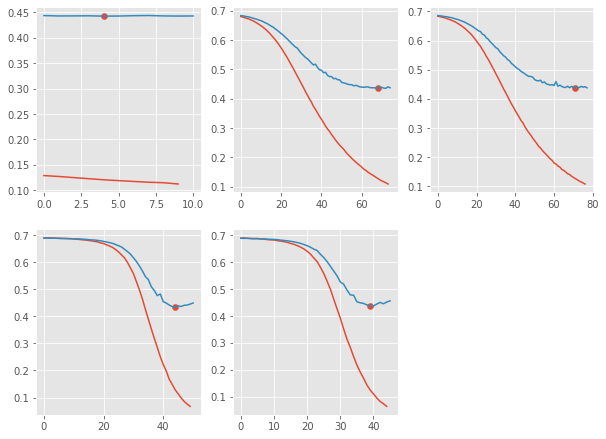

In [23]:
import math
n_rows = math.ceil(len(models['index'])/3)

for i in models['index']:
  plt.subplot(n_rows, 3, i)
  plt.plot(lc_train_l[i-1])
  plt.plot(lc_val_l[i-1])
  plt.scatter(models['epoch'][i-1], models['loss'][i-1])
plt.show()

In [0]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True,
                              num_workers=nproc)
best_model = MLP(in_features, [100], activation=nn.Tanh()).to(device)
best_opt = torch.optim.SGD(best_model.parameters(), lr=0.001, weight_decay=0.001, momentum=0.9)

patience=100
max_epochs=500

lc_train, lc_val, lc_acc = early_stop_train(best_model, best_opt, max_epochs, patience)

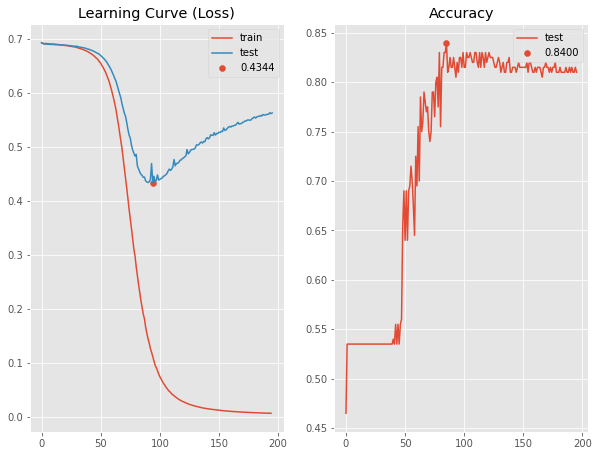

In [26]:
plt.subplot(1, 2, 1)
plt.title("Learning Curve (Loss)")
plt.plot(lc_train)
plt.plot(lc_val)
plt.scatter(np.argmin(lc_val), np.min(lc_val))
plt.legend(['train', 'test', f'{np.min(lc_val):.4f}'])
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(lc_acc)
plt.scatter(np.argmax(lc_acc), np.max(lc_acc))
plt.legend(['test', f'{np.max(lc_acc):.4f}'])
plt.show()

In [27]:
# Num of params
sum([torch.tensor(x.size()).prod() for x in best_model.parameters()])

tensor(260952)

# End of notebook